In [64]:
import numpy as np
from datasets import Dataset
from PIL import Image
import pathlib
from transformers import SamProcessor
from transformers import SamModel, SamConfig
from torch.utils.data import DataLoader
from patchify import patchify
import os
import torch
from torch.optim import Adam
import monai
from transformers import SamModel, SamProcessor
import fishLoader as fish
import dataset_proc as ppf
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import logging
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import platform
import matplotlib.pyplot as plt
import cv2

In [65]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def plt_result(result, img):
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.axis('off')
    show_anns(result)

def grayscale_to_rgb(grayscale_imgs):
    # Initialize an empty array to hold the RGB images
    # The new shape will have an extra dimension for the channels at the end
    rgb_imgs = np.zeros(
        (grayscale_imgs.shape[0], grayscale_imgs.shape[1], 3),
        dtype=np.uint8,
    )

    grayscale_img_uint8 = (grayscale_imgs / 256).astype(np.uint8)
    rgb_imgs = np.stack((grayscale_img_uint8,) * 3, axis=-1)

    return rgb_imgs

def appl_exp(ori):
    exposure_factor = 18
    exposed_image_array = np.clip(ori * exposure_factor, 0, 65535)
    return exposed_image_array

In [66]:
target = pathlib.Path("./201-250_Hong/MAX_CTLa_w1-359 DAPI_s012.tif")
img_org = Image.open(target)
img = cv2.cvtColor(np.array(img_org), cv2.COLOR_GRAY2RGB).astype(np.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [67]:
CP = "fish_v2.1.pth"
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

fish = SamModel(config=model_config)
fish.load_state_dict(torch.load(pathlib.Path("./checkpoints/"+CP)))
fish.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

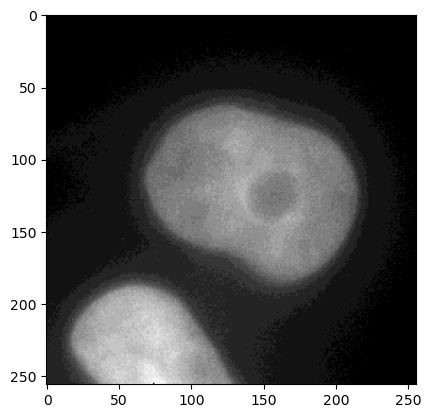

In [68]:
idx = 10
dataset = Dataset.load_from_disk(pathlib.Path("./data"))
example_image = dataset[idx]["image"]
plt.imshow(appl_exp(np.array(example_image)))
plt.show()

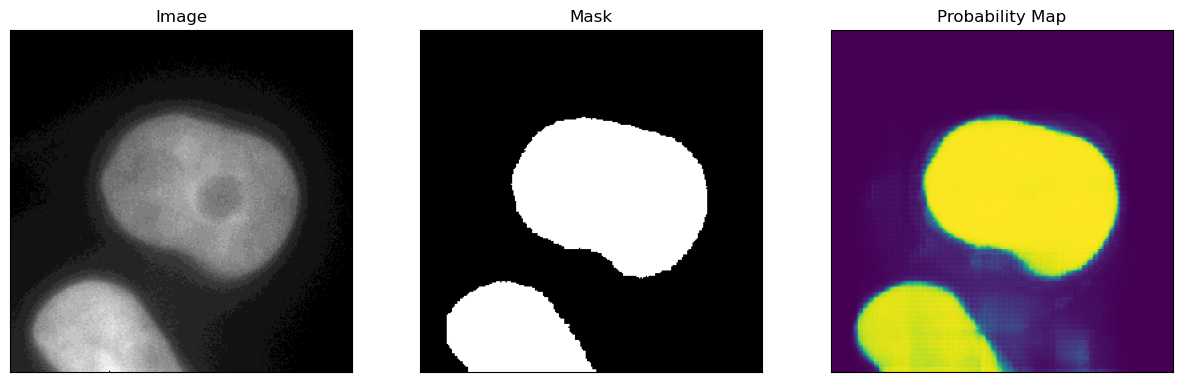

In [69]:
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = ppf.get_bounding_box(ground_truth_mask)
inputs = processor(example_image, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
fish.eval()
with torch.no_grad():
    outputs = fish(**inputs, multimask_output=False)

medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(appl_exp(np.array(example_image)), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()


In [70]:
array_size = 256
grid_size = 10
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)
xv, yv = np.meshgrid(x, y)
xv_list = xv.tolist()
yv_list = yv.tolist()
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

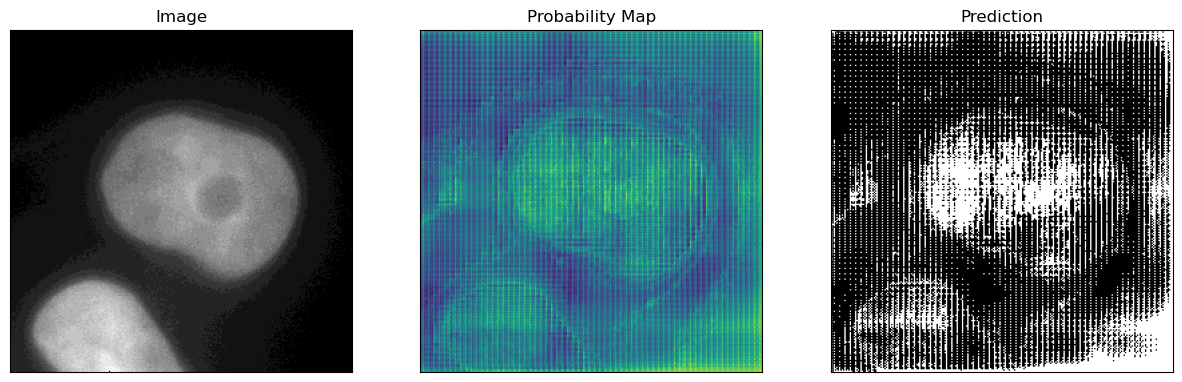

In [71]:
inputs = processor(example_image, input_points=input_points, return_tensors="pt")

inputs = {k: v.to(device) for k, v in inputs.items()}
fish.eval()


with torch.no_grad():
  outputs = fish(**inputs, multimask_output=False)

single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(appl_exp(np.array(example_image)), cmap='gray')
axes[0].set_title("Image")

axes[1].imshow(single_patch_prob)
axes[1].set_title("Probability Map")

axes[2].imshow(single_patch_prediction, cmap='gray')
axes[2].set_title("Prediction")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

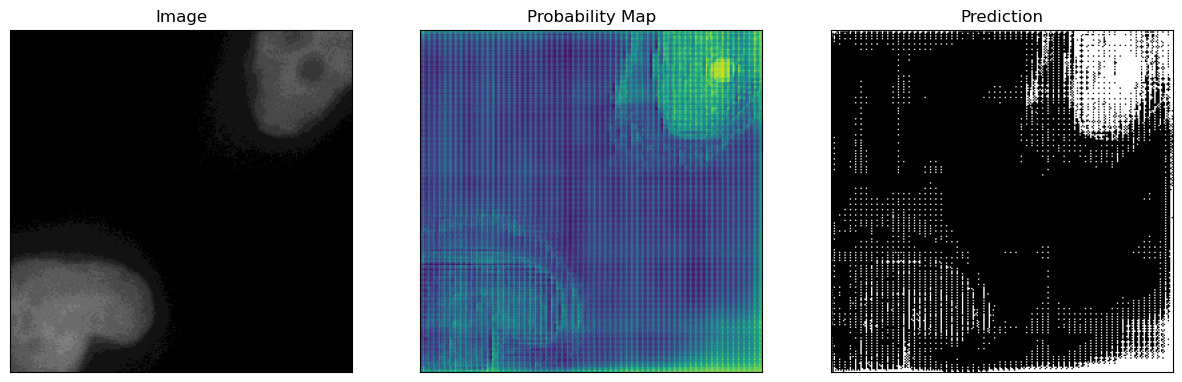

In [72]:
example_outside = Image.open(pathlib.Path("./1-50_Hong/MAX_KOa_w1-359 DAPI_s032.tif"))
o_array_grey = np.array(example_outside)
patches = patchify(o_array_grey, (256, 256), step=256)
i, j = 1, 2
random_array = patches[i, j]
single_patch = Image.fromarray(random_array)
single_patch = grayscale_to_rgb(np.array(single_patch))

## Predict
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

inputs = {k: v.to(device) for k, v in inputs.items()}
fish.eval()


with torch.no_grad():
  outputs = fish(**inputs, multimask_output=False)

single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(appl_exp(np.array(single_patch)), cmap='gray')
axes[0].set_title("Image")

axes[1].imshow(single_patch_prob)
axes[1].set_title("Probability Map")

axes[2].imshow(single_patch_prediction, cmap='gray')
axes[2].set_title("Prediction")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()